## Key findings and achievements

> * Compared three classification models to predict loan approval (Logistic Regression, Decision Tree, Random Forest).
> * Selected the best performing model and carried out predictions on test set.
> * Interpreted the prediction by looking at feature importance.

___

## Introduction

Colorectal cancer is one of the leading causes of cancer-related morbidity and mortality worldwide. Understanding patient survival and recurrence patterns is crucial for improving treatment strategies, optimizing follow-up care, and identifying key risk factors associated with disease progression.


## Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../data/colorectal_cancer_prediction.csv')
df.columns = [col.lower() for col in df.columns]

In [2]:
#|output: false
df.select_dtypes('number').columns

Index(['patient_id', 'age', 'bmi', 'time_to_recurrence'], dtype='object')

In [3]:
#|output: false
object_cols = df.select_dtypes('object').columns

for col in object_cols:
    if df[col].isin(['Yes', 'No']).all():
        df[col] = df[col] == 'Yes'
        
ordinal_mappings = {
    "socioeconomic_status": {"Low": 0, "Middle": 1, "High": 2},
    "stage_at_diagnosis": {"I": 0, "II": 1, "III": 2, "IV": 3},
    "tumor_aggressiveness": {"Low": 0, "Medium": 1, "High": 2},
    "screening_regularity": {"Never": 0, "Irregular": 1, "Regular": 2},
    "physical_activity_level": {"Low": 0, "Medium": 1, "High": 2},
    "alcohol_consumption": {"Low": 0, "Medium": 1, "High": 2},
    "red_meat_consumption": {"Low": 0, "Medium": 1, "High": 2},
    "fiber_consumption": {"Low": 0, "Medium": 1, "High": 2},
    "time_to_diagnosis": {"Delayed": 0, "Timely": 1},
    "treatment_access": {"Limited": 0, "Good": 1},
    "follow_up_adherence": {"Poor": 0, "Good": 1},
}
mapped_df = df.copy()
for col, mapping in ordinal_mappings.items():
    if col in df.columns:
        mapped_df[col] = df[col].map(mapping)
    
for col in object_cols:
    print(f'{col}: {mapped_df[col].unique()}')

gender: ['Male' 'Female']
race: ['Other' 'Black' 'White' 'Hispanic' 'Asian']
region: ['Europe' 'North America' 'Asia Pacific' 'Latin America' 'Africa']
urban_or_rural: ['Urban' 'Rural']
socioeconomic_status: [1 0 2]
family_history: [ True False]
previous_cancer_history: [False  True]
stage_at_diagnosis: [2 0 1 3]
tumor_aggressiveness: [2 1 0]
colonoscopy_access: [False  True]
screening_regularity: [2 0 1]
diet_type: ['Western' 'Balanced' 'Traditional']
physical_activity_level: [0 1 2]
smoking_status: ['Never' 'Former' 'Current']
alcohol_consumption: [0 2 1]
red_meat_consumption: [0 1 2]
fiber_consumption: [0 1 2]
insurance_coverage: [ True False]
time_to_diagnosis: [0 1]
treatment_access: [1 0]
chemotherapy_received: [ True False]
radiotherapy_received: [False  True]
surgery_received: [False  True]
follow_up_adherence: [1 0]
survival_status: ['Survived' 'Deceased']
recurrence: [False  True]


In [4]:
df.head()

patient_id  age  gender   race         region urban_or_rural  \
0           1   71    Male  Other         Europe          Urban   
1           2   34  Female  Black  North America          Urban   
2           3   80  Female  White  North America          Urban   
3           4   40    Male  Black  North America          Rural   
4           5   43  Female  White         Europe          Urban   

  socioeconomic_status  family_history  previous_cancer_history  \
0               Middle            True                    False   
1               Middle           False                    False   
2               Middle           False                    False   
3                  Low           False                    False   
4                 High            True                    False   

  stage_at_diagnosis  ... insurance_coverage  time_to_diagnosis  \
0                III  ...               True            Delayed   
1                  I  ...              False             Timely   
2                III  ...               True             Timely   
3                  I  ...               True            Delayed   
4                III  ...              False            Delayed   

  treatment_access chemotherapy_received  radiotherapy_received  \
0             Good                  True                  False   
1             Good                 False                   True   
2          Limited                 False                   True   
3          Limited                  True                  False   
4             Good                  True                  False   

  surgery_received follow_up_adherence survival_status recurrence  \
0            False                Good        Survived      False   
1             True                Poor        Deceased      False   
2             True                Good        Survived      False   
3             True                Poor        Deceased      False   
4             True                Poor        Deceased       True   

  time_to_recurrence  
0                 16  
1                 28  
2                 26  
3                 44  
4                 20  

[5 rows x 30 columns]

In [5]:
df.columns

Index(['patient_id', 'age', 'gender', 'race', 'region', 'urban_or_rural',
       'socioeconomic_status', 'family_history', 'previous_cancer_history',
       'stage_at_diagnosis', 'tumor_aggressiveness', 'colonoscopy_access',
       'screening_regularity', 'diet_type', 'bmi', 'physical_activity_level',
       'smoking_status', 'alcohol_consumption', 'red_meat_consumption',
       'fiber_consumption', 'insurance_coverage', 'time_to_diagnosis',
       'treatment_access', 'chemotherapy_received', 'radiotherapy_received',
       'surgery_received', 'follow_up_adherence', 'survival_status',
       'recurrence', 'time_to_recurrence'],
      dtype='object')

## Risk of Recurrence
### Exploratory Data Analysis

As a first step of our analysis, we will assess the overall probability of experiencing recurrence.

In [6]:
recurrence_rate = df['recurrence'].value_counts(normalize=True)
recurrence_rate

recurrence
False    0.70015
True     0.29985
Name: proportion, dtype: float64

The overall **risk of recurrence** observed in the data is **29.9%**, meaning that nearly 30% of patients experience a recurrence at some point.

In [7]:
recurrence_odds = recurrence_rate[True] / recurrence_rate[False]
print(f'Odds of recurrence: {round(recurrence_odds * 100, 2)}%')

Odds of recurrence: 42.83%


Regarding the odds, for every 1 patient who does not experience recurrence, about 0.426 patients experience it.

## Time to Recurrence
### Exploratory Data Analysis

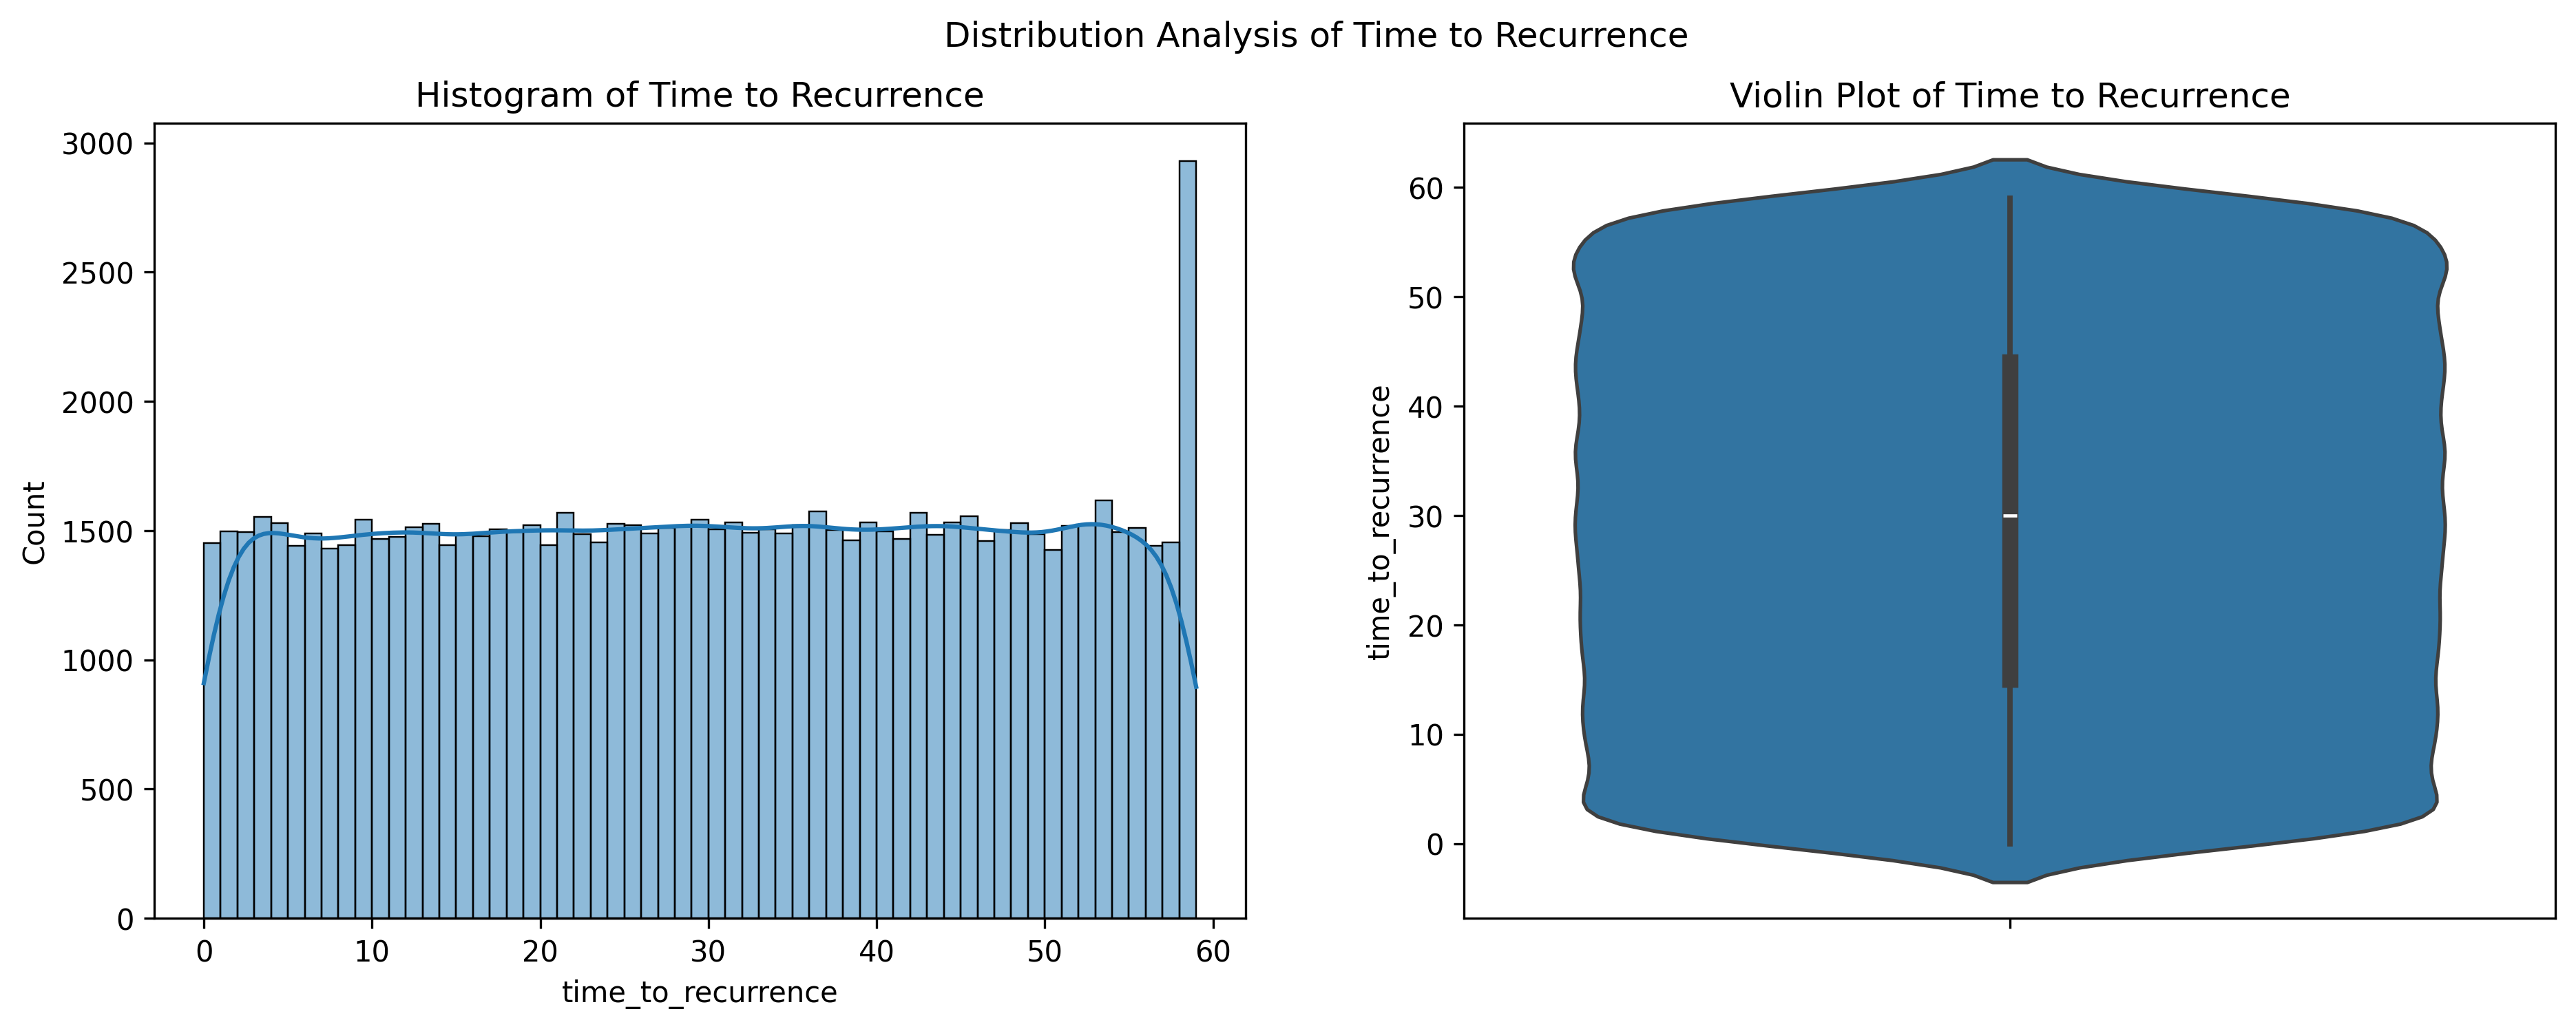

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

sns.histplot(df['time_to_recurrence'], ax=ax[0], kde=True, binwidth=1)
ax[0].set_title("Histogram of Time to Recurrence")

sns.violinplot(y=df['time_to_recurrence'], ax=ax[1])
ax[1].set_title("Violin Plot of Time to Recurrence")

plt.suptitle('Distribution Analysis of Time to Recurrence')
plt.show()

In [10]:
# Identify categorical variables
# object_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Define number of rows and columns for subplots
n_rows = (len(object_cols) + 1) // 2  # Ensures sufficient rows
fig, ax = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows), dpi=300)

# Flatten the axis array for easy iteration
ax = ax.flatten()

# Plot distribution for each categorical variable
for num, col in enumerate(object_cols):
    sns.histplot(df, x='time_to_recurrence', kde=True, binwidth=1, hue=col, ax=ax[num])
    ax[num].set_title(f'Time to Recurrence by {col}')

# Remove any unused subplots
for j in range(num + 1, len(ax)):
    fig.delaxes(ax[j])

# plt.suptitle('Distribution Analysis of Time to Recurrence Across Categories', fontsize=16)
plt.tight_layout()
plt.show()

The histograms show that the time to recurrence appears to be evenly distributed and stable across different categorical variables, with no significant fluctuations based on patient characteristics.

### Survival Analysis

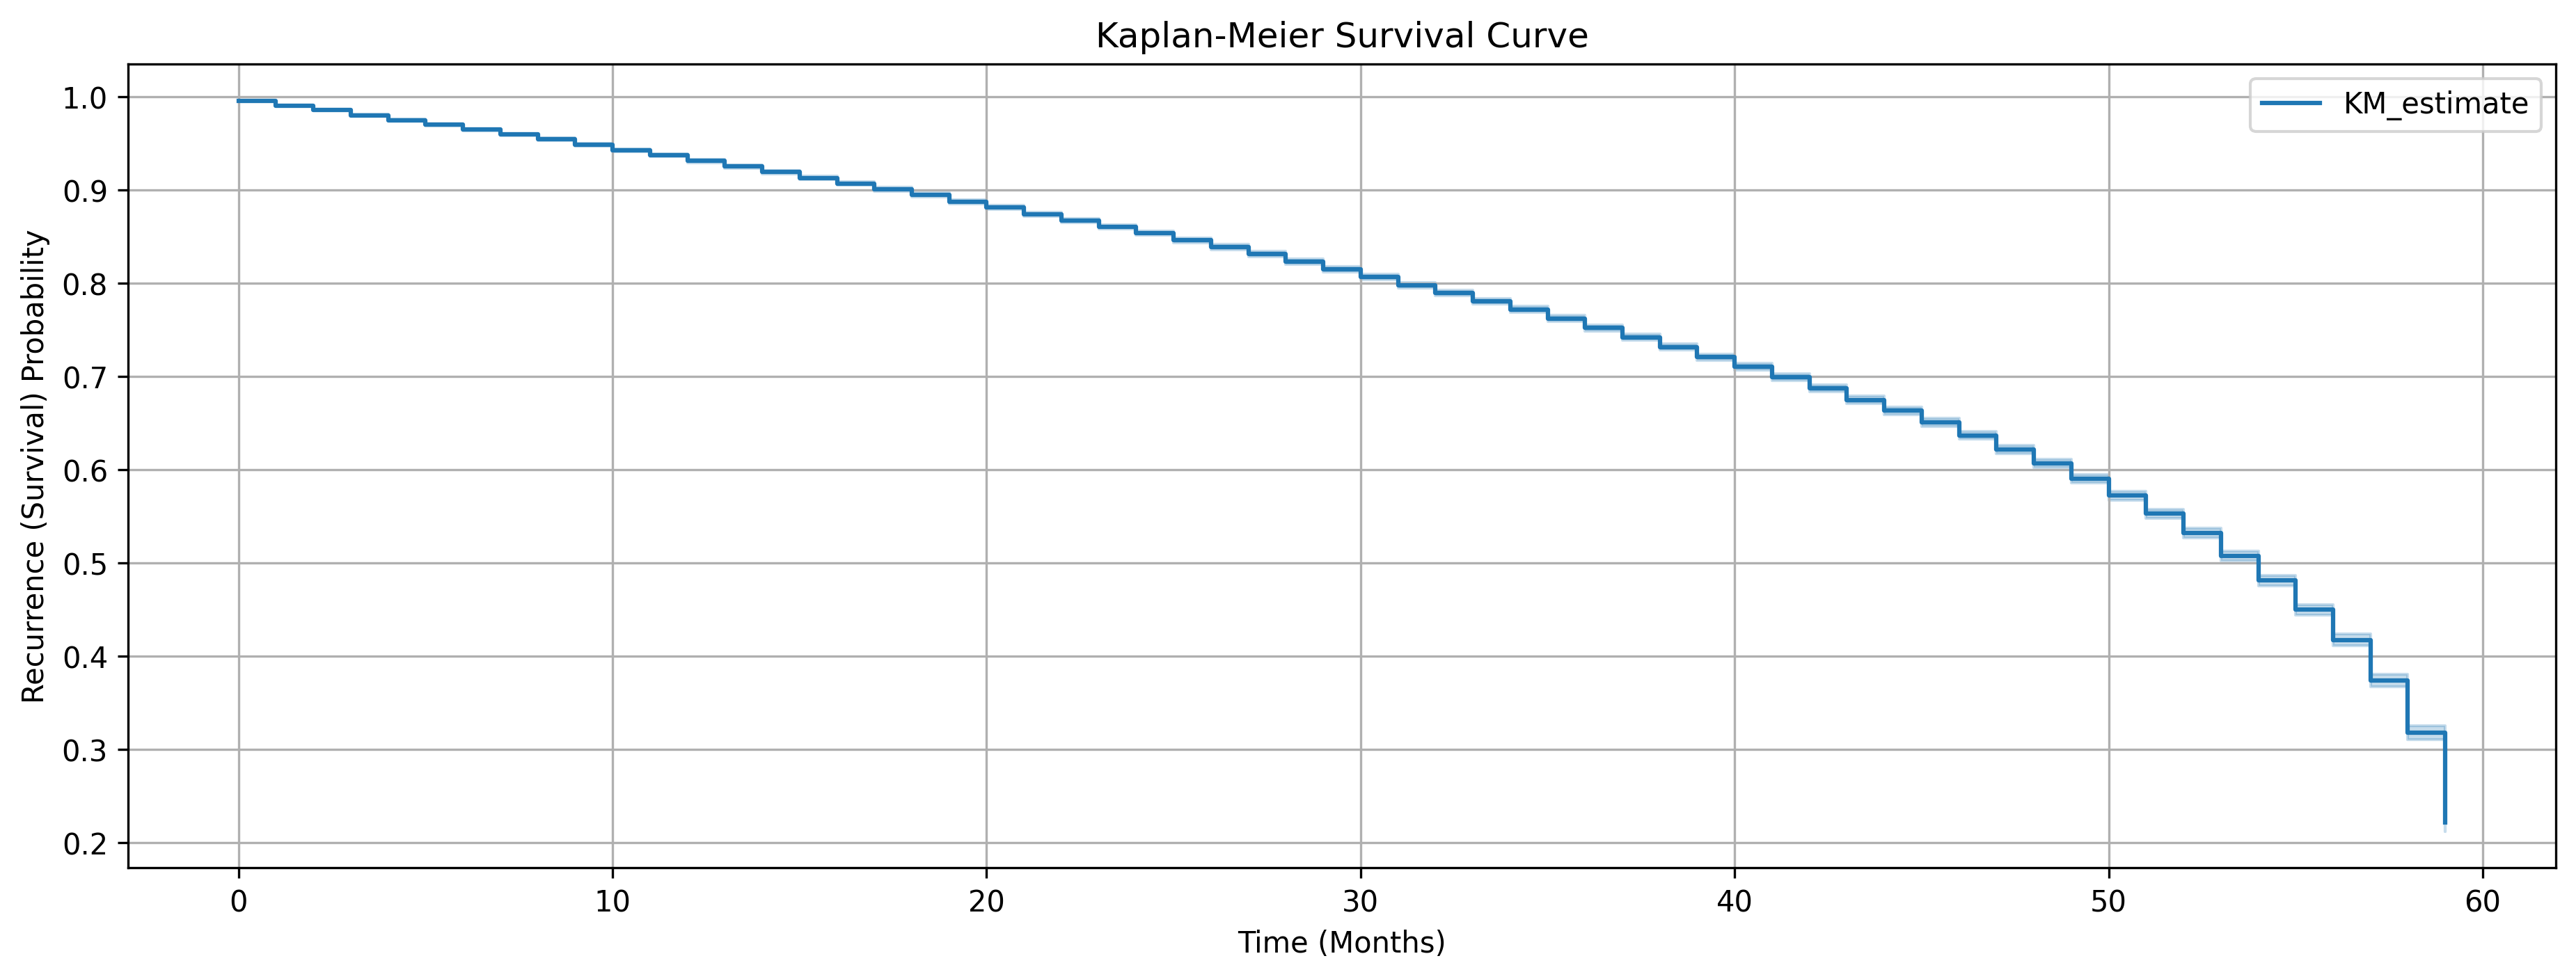

In [11]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(df['time_to_recurrence'], event_observed=df['recurrence'])

plt.figure(figsize=(15, 5), dpi=300)
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (Months)")
plt.ylabel("Recurrence (Survival) Probability")
plt.grid(True)
plt.show()


In [12]:
df_encoded = pd.get_dummies(df)
df_encoded.columns
df_encoded.drop(columns=['patient_id', 'gender_Male', 
                         'race_Other', 'urban_or_rural_Rural', 'region_Europe', 
                         'diet_type_Balanced', 'smoking_status_Never', 
                         'survival_status_Survived'], inplace=True)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# X = df_encoded.drop(columns=['survival_status_Deceased'])
# y = df_encoded['survival_status_Deceased']

X = df_encoded.drop(columns=['recurrence', 'survival_status_Deceased'])
y = df_encoded['recurrence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6964868069967388
Classification Report:
               precision    recall  f1-score   support

       False       0.70      1.00      0.82     18802
        True       0.28      0.00      0.00      8182

    accuracy                           0.70     26984
   macro avg       0.49      0.50      0.41     26984
weighted avg       0.57      0.70      0.57     26984

